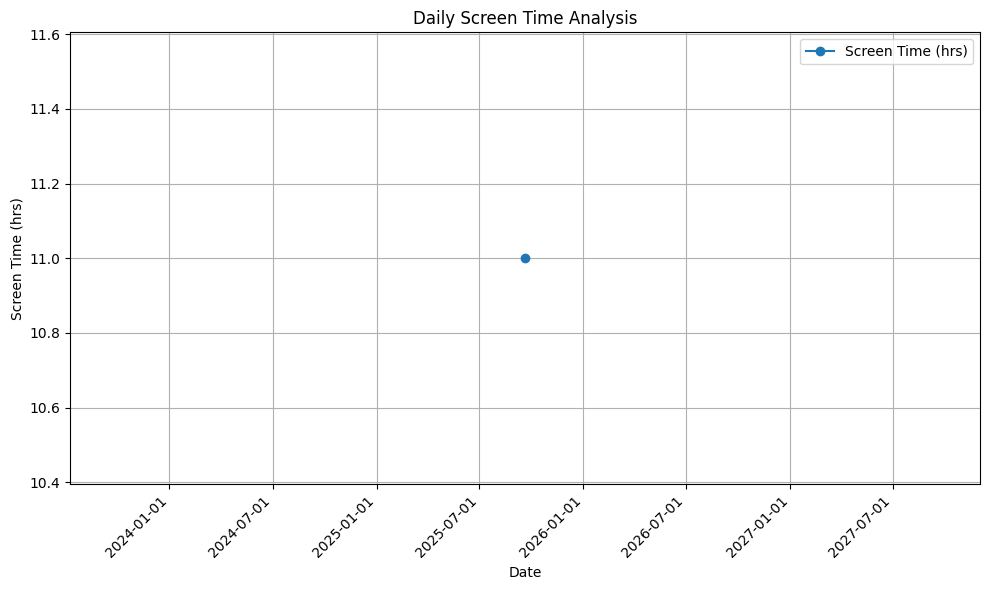

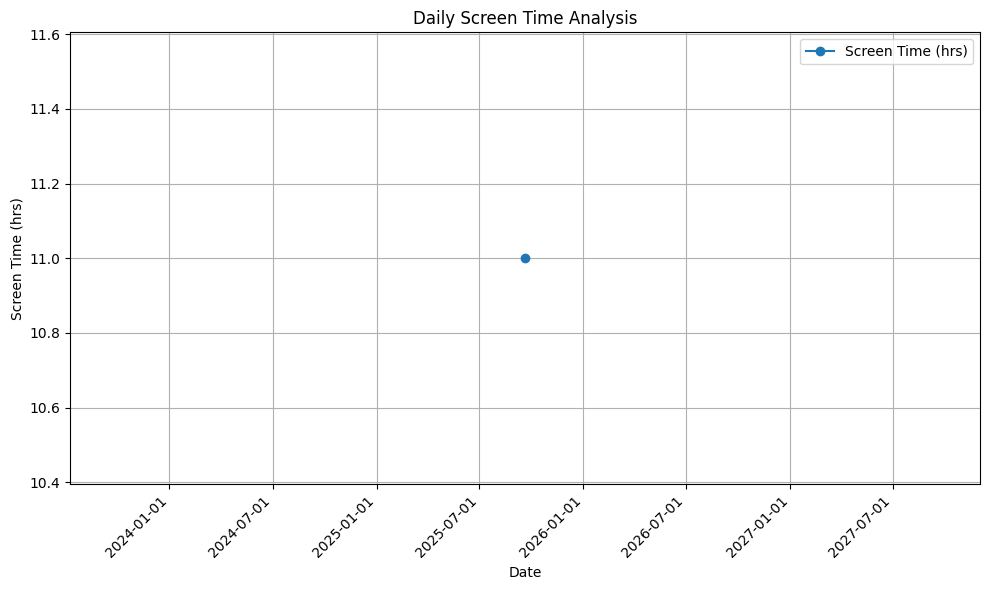

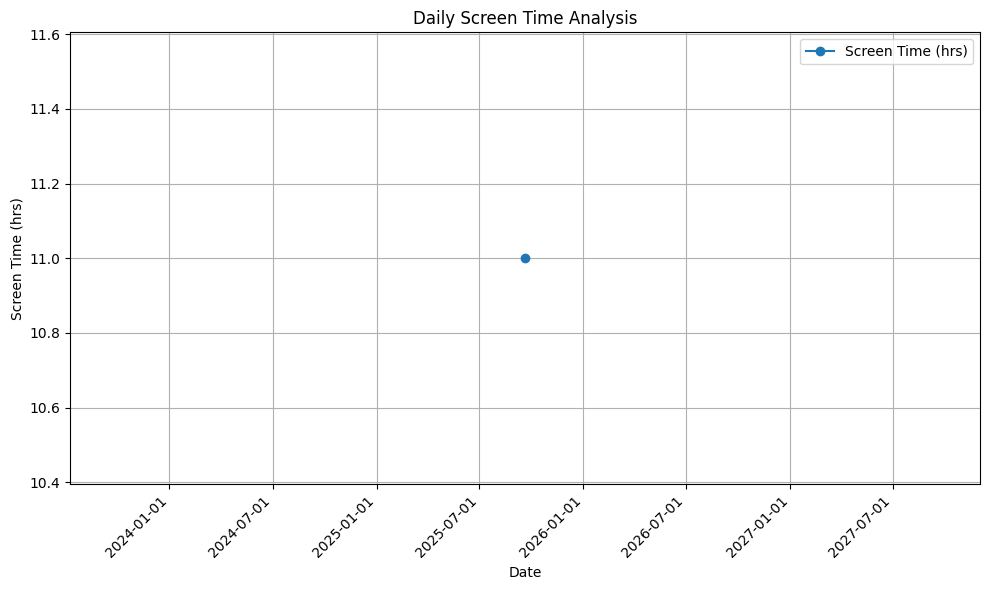

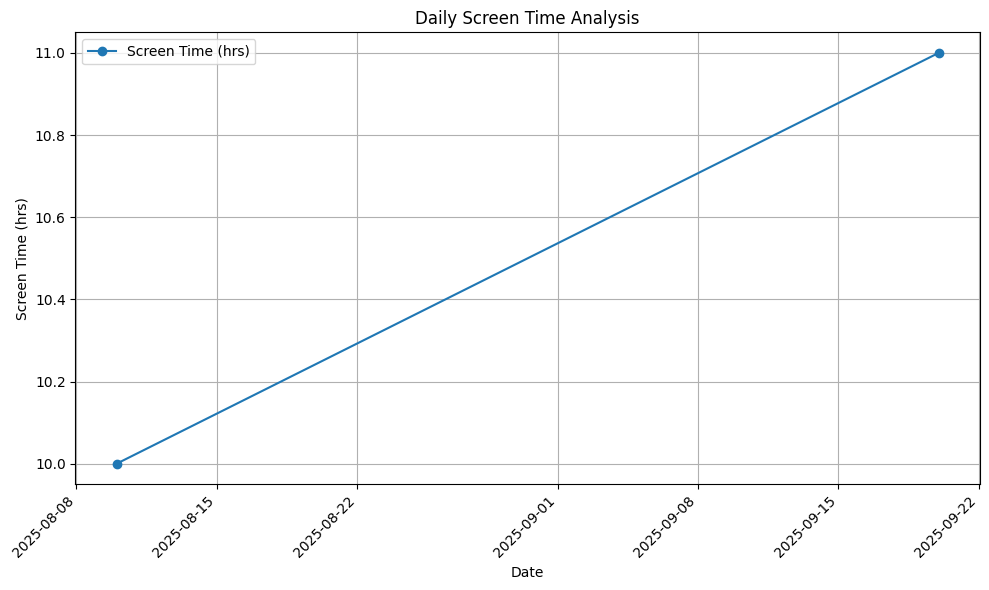

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
import psycopg2
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------- DB CONNECTION ----------
def connect_db():
    """Return a new DB connection (raise exception on failure)."""
    return psycopg2.connect(
        host="localhost",
        database="D_S_T",
        user="postgres",
        password="root"
    )

# ---------- SCHEMA SETUP ----------
def setup_database():
    """Create table if it doesn't exist. Called after root is created so messagebox works."""
    try:
        conn = connect_db()
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS screen_time (
                Date DATE PRIMARY KEY,
                Screen_Time FLOAT,
                Phone_Unlocks INT,
                WhatsApp FLOAT,
                Instagram FLOAT,
                Facebook FLOAT,
                YouTube FLOAT,
                Chrome FLOAT,
                Games FLOAT,
                Others FLOAT
            )
        """)
        conn.commit()
    except Exception as e:
        # show DB error to the user (root must exist for messagebox to work)
        messagebox.showerror("Database Error", f"Failed to setup database:\n{e}")
    finally:
        try:
            cursor.close()
            conn.close()
        except:
            pass

# ---------- SAFE CONVERSION HELPERS ----------
def safe_float(s, default=0.0):
    s = (s or "").strip()
    if s == "":
        return default
    try:
        return float(s)
    except ValueError:
        raise ValueError(f"Expected a number but got: {s}")

def safe_int(s, default=0):
    s = (s or "").strip()
    if s == "":
        return default
    try:
        return int(s)
    except ValueError:
        raise ValueError(f"Expected an integer but got: {s}")

# ---------- SAVE (INSERT / UPSERT) ----------
def save_data():
    try:
        # validate & parse
        date = datetime.strptime(entry_date.get().strip(), "%Y-%m-%d").date()
        screen_time = safe_float(entry_screen_time.get())
        phone_unlocks = safe_int(entry_phone_unlocks.get())
        whatsapp = safe_float(entry_whatsapp.get())
        instagram = safe_float(entry_instagram.get())
        facebook = safe_float(entry_facebook.get())
        youtube = safe_float(entry_youtube.get())
        chrome = safe_float(entry_chrome.get())
        games = safe_float(entry_games.get())
        others = safe_float(entry_others.get())

        conn = connect_db()
        cursor = conn.cursor()

        # Use ON CONFLICT (upsert) so re-submitting same Date updates the row instead of erroring.
        sql = """
            INSERT INTO screen_time
            (Date, Screen_Time, Phone_Unlocks, WhatsApp, Instagram, Facebook, YouTube, Chrome, Games, Others)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (Date) DO UPDATE SET
                Screen_Time = EXCLUDED.Screen_Time,
                Phone_Unlocks = EXCLUDED.Phone_Unlocks,
                WhatsApp = EXCLUDED.WhatsApp,
                Instagram = EXCLUDED.Instagram,
                Facebook = EXCLUDED.Facebook,
                YouTube = EXCLUDED.YouTube,
                Chrome = EXCLUDED.Chrome,
                Games = EXCLUDED.Games,
                Others = EXCLUDED.Others
        """
        params = (date, screen_time, phone_unlocks, whatsapp, instagram, facebook, youtube, chrome, games, others)
        cursor.execute(sql, params)
        conn.commit()
        messagebox.showinfo("Success", "Data saved successfully (inserted/updated).")
        clear_form()
        load_data()
    except ValueError as ve:
        messagebox.showerror("Invalid input", str(ve))
    except Exception as e:
        messagebox.showerror("Error", f"Failed to save data: {e}")
    finally:
        try:
            cursor.close()
            conn.close()
        except:
            pass

# ---------- LOAD / DISPLAY ----------
def load_data():
    # clear tree
    for item in tree.get_children():
        tree.delete(item)
    try:
        conn = connect_db()
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM screen_time ORDER BY Date DESC")
        rows = cursor.fetchall()
        for row in rows:
            # format date for display (row[0] is a date object)
            date_str = row[0].strftime("%Y-%m-%d") if row[0] else ""
            values = (date_str,) + tuple(row[1:])
            tree.insert("", tk.END, values=values)
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load data: {e}")
    finally:
        try:
            cursor.close()
            conn.close()
        except:
            pass

# ---------- FORM HELP ----------
def clear_form():
    for e in entries:
        e.delete(0, tk.END)

# ---------- ANALYSIS / PLOTTING ----------
def analyze_data():
    try:
        conn = connect_db()
        cursor = conn.cursor()
        cursor.execute("SELECT Date, Screen_Time FROM screen_time ORDER BY Date")
        data = cursor.fetchall()
        if not data:
            messagebox.showinfo("No Data", "No data available for analysis.")
            return

        dates = [row[0] for row in data]        # list of datetime.date
        screen_time = [row[1] for row in data] # list of floats

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(dates, screen_time, marker="o", linestyle="-", label="Screen Time (hrs)")

        # Use AutoDateLocator/DateFormatter for readable x-axis (works for many ranges)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate(rotation=45)
        ax.set_title("Daily Screen Time Analysis")
        ax.set_xlabel("Date")
        ax.set_ylabel("Screen Time (hrs)")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        messagebox.showerror("Error", f"Failed to analyze data: {e}")
    finally:
        try:
            cursor.close()
            conn.close()
        except:
            pass

# ---------- BUILD GUI ----------
root = tk.Tk()
root.title("Screen Time Tracker")
root.geometry("950x700")
root.configure(bg="lightgray")

# Create DB schema now (root exists, so messagebox can be used if needed)
setup_database()

tk.Label(root, text="Screen Time Tracker", font=("Arial", 20, "bold"), bg="lightgray", fg="blue").pack(pady=10)

frame_form = tk.Frame(root, bg="lightgray")
frame_form.pack(pady=10)

labels = [
    "Date (YYYY-MM-DD):", "Screen Time (hrs):", "Phone Unlocks:",
    "WhatsApp Usage:", "Instagram Usage:", "Facebook Usage:",
    "YouTube Usage:", "Chrome Usage:", "Games Usage:", "Others Usage:"
]

entries = []
for i, label_text in enumerate(labels):
    tk.Label(frame_form, text=label_text, font=("Arial", 12), bg="lightgray").grid(row=i, column=0, sticky="w", padx=10, pady=5)
    entry = tk.Entry(frame_form, width=30)
    entry.grid(row=i, column=1, padx=10, pady=5)
    entries.append(entry)

(entry_date, entry_screen_time, entry_phone_unlocks,
 entry_whatsapp, entry_instagram, entry_facebook,
 entry_youtube, entry_chrome, entry_games, entry_others) = entries

frame_buttons = tk.Frame(root, bg="lightgray")
frame_buttons.pack(pady=10)

tk.Button(frame_buttons, text="Save Data", command=save_data, bg="green", fg="white", font=("Arial", 12)).pack(side="left", padx=10)
tk.Button(frame_buttons, text="Analyze Data", command=analyze_data, bg="orange", fg="white", font=("Arial", 12)).pack(side="left", padx=10)

frame_table = tk.Frame(root, bg="lightgray")
frame_table.pack(pady=10)

columns = ["Date", "Screen Time", "Phone Unlocks", "WhatsApp", "Instagram", "Facebook", "YouTube", "Chrome", "Games", "Others"]
tree = ttk.Treeview(frame_table, columns=columns, show="headings", height=15)
for i, col in enumerate(columns):
    tree.heading(col, text=col)
    tree.column(col, width=100 if i>0 else 120, anchor="center")
tree.pack(pady=20)

# Load existing data into the table
load_data()

root.mainloop()
